# import

In [ ]:
# !pip install --upgrade timm
# !pip uninstall torch
# !pip install torch==2.0.1

In [5]:
import torch
from torch import nn
import torch.nn.functional as F
import torchvision
import math
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset
import pandas as pd
import numpy as np
from  PIL import Image
import os
import random
from tqdm import tqdm
import timm
import sys
sys.path.insert(0, '../input/tiny-vit-model')
import tiny_vit

# 定义参数

In [6]:
INPUT_PATH = '../input/mymodelparam'
TRAIN_CSV_PATH = '../input/cassava-leaf-disease-classification/train.csv'
TRAIN_IMAGE_PATH = '../input/cassava-leaf-disease-classification/train_images/'
TEST_IMAGE_PATH = '../input/cassava-leaf-disease-classification/test_images/'
SUBMISSION_PATH = 'submission.csv'
DEVICES = [torch.device(f'cuda:{i}') for i in range(torch.cuda.device_count())]
OUT_CLASSES = 5
NUM_EPOCHS = 13
BATCH_SIZE = 16
IMAGE_SIZE =  512
OPTIMIZER = torch.optim.AdamW
SEED = 42
LR_START = 1e-5
LR_MAX = 2e-4
LR_FINAL = 1e-5
TTA = 5
T1 = 0.8
T2 = 1.4
SMOOTHING = 0.06

# tr1.损失函数
1st solution's loss
1. B4: Sigmoid Focal Cross Entropy Loss: is good for class imbalance problems / label smoothing
2. ResNeXt50: Cross Entropy Loss
3. ViT: bi-tempered-loss

In [ ]:
import torch


def log_t(u, t):
    """Compute log_t for `u'."""
    if t == 1.0:
        return u.log()
    else:
        return (u.pow(1.0 - t) - 1.0) / (1.0 - t)


def exp_t(u, t):
    """Compute exp_t for `u'."""
    if t == 1:
        return u.exp()
    else:
        return (1.0 + (1.0 - t) * u).relu().pow(1.0 / (1.0 - t))


def compute_normalization_fixed_point(activations, t, num_iters):
    """Returns the normalization value for each example (t > 1.0).

    Args:
      activations: A multi-dimensional tensor with last dimension `num_classes`.
      t: Temperature 2 (> 1.0 for tail heaviness).
      num_iters: Number of iterations to run the method.
    Return: A tensor of same shape as activation with the last dimension being 1.
    """
    mu, _ = torch.max(activations, -1, keepdim=True)
    normalized_activations_step_0 = activations - mu

    normalized_activations = normalized_activations_step_0

    for _ in range(num_iters):
        logt_partition = torch.sum(
            exp_t(normalized_activations, t), -1, keepdim=True)
        normalized_activations = normalized_activations_step_0 * \
                                 logt_partition.pow(1.0 - t)

    logt_partition = torch.sum(
        exp_t(normalized_activations, t), -1, keepdim=True)
    normalization_constants = - log_t(1.0 / logt_partition, t) + mu

    return normalization_constants


def compute_normalization_binary_search(activations, t, num_iters):
    """Returns the normalization value for each example (t < 1.0).

    Args:
      activations: A multi-dimensional tensor with last dimension `num_classes`.
      t: Temperature 2 (< 1.0 for finite support).
      num_iters: Number of iterations to run the method.
    Return: A tensor of same rank as activation with the last dimension being 1.
    """

    mu, _ = torch.max(activations, -1, keepdim=True)
    normalized_activations = activations - mu

    effective_dim = \
        torch.sum(
            (normalized_activations > -1.0 / (1.0 - t)).to(torch.int32),
            dim=-1, keepdim=True).to(activations.dtype)

    shape_partition = activations.shape[:-1] + (1,)
    lower = torch.zeros(shape_partition, dtype=activations.dtype, device=activations.device)
    upper = -log_t(1.0 / effective_dim, t) * torch.ones_like(lower)

    for _ in range(num_iters):
        logt_partition = (upper + lower) / 2.0
        sum_probs = torch.sum(
            exp_t(normalized_activations - logt_partition, t),
            dim=-1, keepdim=True)
        update = (sum_probs < 1.0).to(activations.dtype)
        lower = torch.reshape(
            lower * update + (1.0 - update) * logt_partition,
            shape_partition)
        upper = torch.reshape(
            upper * (1.0 - update) + update * logt_partition,
            shape_partition)

    logt_partition = (upper + lower) / 2.0
    return logt_partition + mu


class ComputeNormalization(torch.autograd.Function):
    """
    Class implementing custom backward pass for compute_normalization. See compute_normalization.
    """

    @staticmethod
    def forward(ctx, activations, t, num_iters):
        if t < 1.0:
            normalization_constants = compute_normalization_binary_search(activations, t, num_iters)
        else:
            normalization_constants = compute_normalization_fixed_point(activations, t, num_iters)

        ctx.save_for_backward(activations, normalization_constants)
        ctx.t = t
        return normalization_constants

    @staticmethod
    def backward(ctx, grad_output):
        activations, normalization_constants = ctx.saved_tensors
        t = ctx.t
        normalized_activations = activations - normalization_constants
        probabilities = exp_t(normalized_activations, t)
        escorts = probabilities.pow(t)
        escorts = escorts / escorts.sum(dim=-1, keepdim=True)
        grad_input = escorts * grad_output

        return grad_input, None, None


def compute_normalization(activations, t, num_iters=5):
    """Returns the normalization value for each example.
    Backward pass is implemented.
    Args:
      activations: A multi-dimensional tensor with last dimension `num_classes`.
      t: Temperature 2 (> 1.0 for tail heaviness, < 1.0 for finite support).
      num_iters: Number of iterations to run the method.
    Return: A tensor of same rank as activation with the last dimension being 1.
    """
    return ComputeNormalization.apply(activations, t, num_iters)


def tempered_sigmoid(activations, t, num_iters=5):
    """Tempered sigmoid function.

    Args:
      activations: Activations for the positive class for binary classification.
      t: Temperature tensor > 0.0.
      num_iters: Number of iterations to run the method.

    Returns:
      A probabilities tensor.
    """
    internal_activations = torch.stack([activations,
                                        torch.zeros_like(activations)],
                                       dim=-1)
    internal_probabilities = tempered_softmax(internal_activations, t, num_iters)
    return internal_probabilities[..., 0]


def tempered_softmax(activations, t, num_iters=5):
    """Tempered softmax function.
    Args:
      activations: A multi-dimensional tensor with last dimension `num_classes`.
      t: Temperature > 1.0.
      num_iters: Number of iterations to run the method.
    Returns:
      A probabilities tensor.
    """
    if t == 1.0:
        return activations.softmax(dim=-1)

    normalization_constants = compute_normalization(activations, t, num_iters)
    return exp_t(activations - normalization_constants, t)


def bi_tempered_binary_logistic_loss(activations,
                                     labels,
                                     t1,
                                     t2,
                                     label_smoothing=0.0,
                                     num_iters=5,
                                     reduction='mean'):
    """Bi-Tempered binary logistic loss.

    Args:
      activations: A tensor containing activations for class 1.
      labels: A tensor with shape as activations, containing probabilities for class 1
      t1: Temperature 1 (< 1.0 for boundedness).
      t2: Temperature 2 (> 1.0 for tail heaviness, < 1.0 for finite support).
      label_smoothing: Label smoothing
      num_iters: Number of iterations to run the method.

    Returns:
      A loss tensor.
    """
    internal_activations = torch.stack([activations,
                                        torch.zeros_like(activations)],
                                       dim=-1)
    internal_labels = torch.stack([labels.to(activations.dtype),
                                   1.0 - labels.to(activations.dtype)],
                                  dim=-1)
    return bi_tempered_logistic_loss(internal_activations,
                                     internal_labels,
                                     t1,
                                     t2,
                                     label_smoothing=label_smoothing,
                                     num_iters=num_iters,
                                     reduction=reduction)


def bi_tempered_logistic_loss(activations,
                              labels,
                              t1,
                              t2,
                              label_smoothing=0.0,
                              num_iters=5,
                              reduction='mean'):
    """Bi-Tempered Logistic Loss.
    Args:
      activations: A multi-dimensional tensor with last dimension `num_classes`.
      labels: A tensor with shape and dtype as activations (onehot),
        or a long tensor of one dimension less than activations (pytorch standard)
      t1: Temperature 1 (< 1.0 for boundedness).
      t2: Temperature 2 (> 1.0 for tail heaviness, < 1.0 for finite support).
      label_smoothing: Label smoothing parameter between [0, 1). Default 0.0.
      num_iters: Number of iterations to run the method. Default 5.
      reduction: ``'none'`` | ``'mean'`` | ``'sum'``. Default ``'mean'``.
        ``'none'``: No reduction is applied, return shape is shape of
        activations without the last dimension.
        ``'mean'``: Loss is averaged over minibatch. Return shape (1,)
        ``'sum'``: Loss is summed over minibatch. Return shape (1,)
    Returns:
      A loss tensor.
    """

    if len(labels.shape) < len(activations.shape):  # not one-hot
        labels_onehot = torch.zeros_like(activations)
        labels_onehot.scatter_(1, labels[..., None], 1)
    else:
        labels_onehot = labels

    if label_smoothing > 0:
        num_classes = labels_onehot.shape[-1]
        labels_onehot = (1 - label_smoothing * num_classes / (num_classes - 1)) \
                        * labels_onehot + \
                        label_smoothing / (num_classes - 1)

    probabilities = tempered_softmax(activations, t2, num_iters)

    loss_values = labels_onehot * log_t(labels_onehot + 1e-10, t1) \
                  - labels_onehot * log_t(probabilities, t1) \
                  - labels_onehot.pow(2.0 - t1) / (2.0 - t1) \
                  + probabilities.pow(2.0 - t1) / (2.0 - t1)
    loss_values = loss_values.sum(dim=-1)  # sum over classes

    if reduction == 'none':
        return loss_values
    if reduction == 'sum':
        return loss_values.sum()
    if reduction == 'mean':
        return loss_values.mean()


# tr2.learning_rate

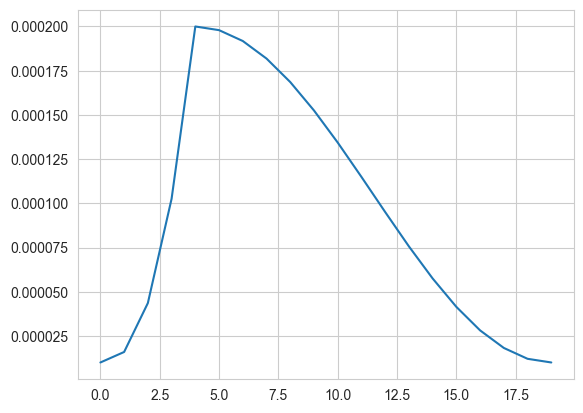

In [4]:
def lr_tune(epoch, num_epochs=NUM_EPOCHS):
    lr_start = LR_START
    lr_max = LR_MAX
    lr_final = LR_FINAL
    lr_warmup_epoch = 4
    lr_sustain_epoch = 0
    lr_decay_epoch = num_epochs - lr_warmup_epoch - lr_sustain_epoch - 1

    if epoch <= lr_warmup_epoch:
        lr = lr_start + (lr_max - lr_start) * (epoch / lr_warmup_epoch) ** 2.5
    elif epoch < lr_warmup_epoch + lr_sustain_epoch:
        lr = lr_max
    else:
        epoch_diff = epoch - lr_warmup_epoch - lr_sustain_epoch
        decay_factor = (epoch_diff / lr_decay_epoch) * math.pi
        decay_factor = (torch.cos(torch.tensor(decay_factor)).numpy() + 1) / 2
        lr = lr_final + (lr_max - lr_final) * decay_factor
    return lr
x = [i for i in range(NUM_EPOCHS)]
y = [lr_tune(i) for i in x]
plt.plot(x, y)

# tr3.albumentations

In [5]:
train_augs = A.Compose(
    [
        A.RandomResizedCrop(IMAGE_SIZE, IMAGE_SIZE),
        A.Transpose(p=0.5),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.ShiftScaleRotate(p=0.5),
        A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5),
        A.RandomBrightnessContrast(brightness_limit=(-0.1, 0.1), contrast_limit=(-0.1, 0.1), p=0.5),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0, p=1.0),
        A.CoarseDropout(p=0.5),
        A.Cutout(p=0.5),
        ToTensorV2(p=1.0)
    ], p=1.0)
valid_augs = A.Compose(
    [
        A.Resize(IMAGE_SIZE, IMAGE_SIZE),
        A.CenterCrop(IMAGE_SIZE, IMAGE_SIZE),
        A.Normalize(
             mean=[0.485, 0.456, 0.406],
             std=[0.229, 0.224, 0.225]
        ),
        ToTensorV2(),
    ]
)

# tr4.TTA

In [ ]:
test_augs = A.Compose([
    A.OneOf([
        A.Resize(IMAGE_SIZE, IMAGE_SIZE, p=1.0),
        A.CenterCrop(IMAGE_SIZE, IMAGE_SIZE, p=1.0),
        A.RandomResizedCrop(IMAGE_SIZE, IMAGE_SIZE, p=1.0)
    ], p=1.0),
    A.Transpose(p=0.5),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Resize(IMAGE_SIZE, IMAGE_SIZE),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0, p=1.0),
    ToTensorV2(p=1.0)
    ], p=1.0
)

# tr5.seed

In [ ]:
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
# os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
seed_everything(SEED)

# 定义数据集

In [ ]:
class MyCassavaLeafDataset(Dataset):
    @staticmethod
    def generate_index(num_total, ratio):
        if ratio != 0.0:
            all_index = [i for i in range(num_total)]
            k = ratio * 10
            valid_index = np.arange(0, num_total, k)
            train_index = [i for i in all_index if i not in valid_index]
            return train_index, valid_index
        else:
            return [i for i in range(num_total)], []

    def __init__(self, csv_path=None, images_path=None, transform=None, mode='train', train_ratio=0.5):
        super().__init__()
        self.transform = transform
        self.mode = mode
        self.images_path = images_path
        self.data_info = pd.read_csv(csv_path)
        self.data_len = self.data_info.shape[0]
        if self.mode == 'train':
            train_index, _ = MyCassavaLeafDataset.generate_index(self.data_len, train_ratio)
            self.image_arr = np.asarray(self.data_info.iloc[train_index, 0])
            self.label_arr = np.asarray(self.data_info.iloc[train_index, 1])
            self.real_len = len(self.image_arr)
        elif self.mode == 'valid':
            _, valid_index = MyCassavaLeafDataset.generate_index(self.data_len, train_ratio)
            self.image_arr = np.asarray(self.data_info.iloc[valid_index, 0])
            self.label_arr = np.asarray(self.data_info.iloc[valid_index, 1])
            self.real_len = len(self.image_arr)

    def __getitem__(self, index):
        if self.mode != 'test':
            single_image_name = self.image_arr[index]
            image = Image.open(os.path.join(self.images_path, single_image_name))
            image = np.array(image)
            label = self.label_arr[index]
            return self.transform(image=image)["image"], label


    def __len__(self):
        return self.real_len

In [ ]:
train_set = MyCassavaLeafDataset(csv_path=TRAIN_CSV_PATH, images_path=TRAIN_IMAGE_PATH, transform=train_augs, mode='train', train_ratio=0.0)
my_train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
valid_set = MyCassavaLeafDataset(csv_path=TRAIN_CSV_PATH, images_path=TRAIN_IMAGE_PATH, transform=valid_augs, mode='valid')
my_valid_dataloader = torch.utils.data.DataLoader(valid_set, batch_size=BATCH_SIZE, shuffle=False)

# 定义模型

In [23]:
my_model = tiny_vit.tiny_vit_21m_512(pretrained=True)
my_model.head = nn.Linear(my_model.head.in_features, OUT_CLASSES)
nn.init.xavier_uniform_(my_model.head.weight)
if my_model.head.bias is not None:
    nn.init.zeros_(my_model.head.bias)

TinyViT(
  (patch_embed): PatchEmbed(
    (seq): Sequential(
      (0): Conv2d_BN(
        (c): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): GELU(approximate='none')
      (2): Conv2d_BN(
        (c): Conv2d(48, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
  )
  (layers): ModuleList(
    (0): ConvLayer(
      (blocks): ModuleList(
        (0): MBConv(
          (conv1): Conv2d_BN(
            (c): Conv2d(96, 384, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
          (act1): GELU(approximate='none')
          (conv2): Conv2d_BN(
            (c): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=

# 定义训练

In [ ]:
class MyTrainer:
    @staticmethod
    def accurate_count(y_hat, y_true):
        y_hat = y_hat.argmax(axis=1)
        y_true = y_true.argmax(axis=1)
        correct_count = 0
        for i in range(len(y_hat)):
            if y_hat[i].type(y_true.dtype) == y_true[i]:
                correct_count += 1
        return float(correct_count)
    @staticmethod
    def calc_valid_acc(model, valid_dataloader):
        model.eval()
        device = next(iter(model.parameters())).device
        test_num = 0
        test_acc_num = 0
        for x, y_true in valid_dataloader:
            if isinstance(x, list):
                x = [x_1.to(device) for x_1 in x]
            else:
                x = x.to(device)
            y_true_tensor = torch.zeros(size=(len(y_true), OUT_CLASSES))
            for i in range(len(y_true)):
                label = y_true[i]
                y_true_tensor[i, label] = 1
            y_true = y_true_tensor
            y_true = y_true.to(device)
            test_num += y_true.shape[0]
            test_acc_num += MyTrainer.accurate_count(model(x), y_true)
        return test_acc_num / test_num

    def __init__(self, optimizer, model, criterion, train_dataloader, valid_dataloader, param_group=True, learning_rate=lr_tune, num_epochs=NUM_EPOCHS, devices=DEVICES):
        self.optimizer_class = optimizer
        self.model = model
        self.criterion = criterion
        self.devices = devices
        self.train_dataloader = train_dataloader
        self.valid_dataloader = valid_dataloader
        self.param_group = param_group
        self.learning_rate = learning_rate
        self.num_epochs = num_epochs
    def train_epoch(self, epoch):
        self.model.train()
        total_loss = 0
        train_num = 0
        train_acc_num = 0
        batch_num = len(self.train_dataloader)
        param_1x = [param for name, param in self.model.named_parameters() if
                    name not in ['module.head.weight', 'module.head.bias']]
        optimizer = self.optimizer_class([{'params': param_1x},
                            {'params': self.model.module.head.parameters(),
                            'lr': self.learning_rate(epoch) * 10}],
                            lr=self.learning_rate(epoch), weight_decay=0.001)
        print(f'epoch{epoch + 1} begins:')
        tk0 = tqdm(enumerate(self.train_dataloader), total=batch_num)
        for batch_idx, (x, y_true) in tk0:
            y_true_tensor = torch.zeros(size=(len(y_true), OUT_CLASSES))
            for i in range(len(y_true)):
                label = y_true[i]
                y_true_tensor[i, label] = 1
            y_true = y_true_tensor
            x, y_true = x.to(self.devices[0]), y_true.to(self.devices[0])
            optimizer.zero_grad()
            y_hat = self.model(x)
            loss = self.criterion(y_hat, y_true, T1, T2, SMOOTHING)
            loss.sum().backward()
            optimizer.step()
            total_loss += loss.sum()
            train_num += y_true.shape[0]
            train_acc_num += MyTrainer.accurate_count(y_hat, y_true)

        return total_loss / train_num, train_acc_num / train_num
    def train(self):
        best_valid_acc = 0
        self.model = nn.DataParallel(self.model ,device_ids=self.devices).to(self.devices[0])
        for epoch in range(self.num_epochs):
            train_loss, train_acc = MyTrainer.train_epoch(self, epoch)
            if epoch == self.num_epochs - 1:
                torch.save(self.model.state_dict(), os.path.join('tinyvit.pth'))
            print(f'epoch{epoch + 1}:train_loss:{train_loss}, train_acc:{train_acc}')

# 训练

In [ ]:
torch.cuda.empty_cache()

In [ ]:
my_criterion = bi_tempered_logistic_loss
my_trainer = MyTrainer(OPTIMIZER, my_model, my_criterion, my_train_dataloader, my_valid_dataloader)
my_trainer.train()